# TD7: Deep Q Network : Reinforcement Learning

Chargement des données et plot de la serie d'entrainement.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import deque
import sys
import math
import keras
from keras.models import load_model
from tqdm import tqdm_notebook as tqdm

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

gpu_devices = tensorflow.config.experimental.list_physical_devices('GPU')    
for device in gpu_devices:
	tensorflow.config.experimental.set_memory_growth(device, True)

In [ ]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD7/TP7_q_trader/q_trader/')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD7/TP7_q_trader/q_trader


In [ ]:
Data = pd.read_csv('data/^GSPC_2011.csv',index_col=0)
Data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,1257.619995,1276.170044,1257.619995,1271.869995,1271.869995,4286670000
2011-01-04,1272.949951,1274.119995,1262.660034,1270.199951,1270.199951,4796420000
2011-01-05,1268.780029,1277.630005,1265.359985,1276.560059,1276.560059,4764920000
2011-01-06,1276.290039,1278.170044,1270.430054,1273.849976,1273.849976,4844100000
2011-01-07,1274.410034,1276.829956,1261.699951,1271.500000,1271.500000,4963110000
...,...,...,...,...,...,...
2011-12-23,1254.000000,1265.420044,1254.000000,1265.329956,1265.329956,2233830000
2011-12-27,1265.020020,1269.369995,1262.300049,1265.430054,1265.430054,2130590000
2011-12-28,1265.380005,1265.849976,1248.640015,1249.640015,1249.640015,2349980000


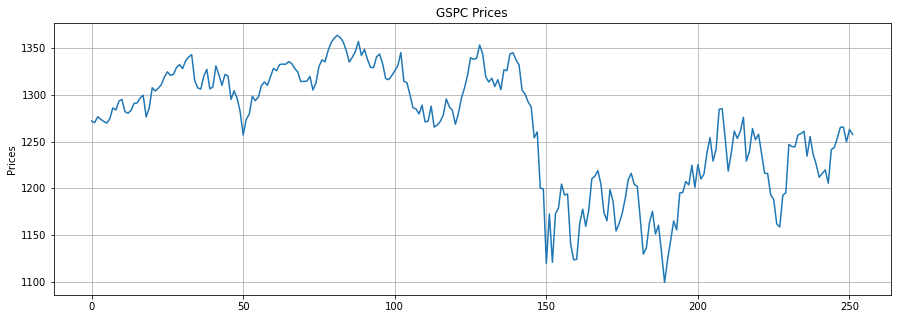

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(np.arange(0,Data.shape[0],1),Data["Adj Close"],label = "GSPC");
plt.ylabel('Prices');
plt.title('GSPC Prices');
plt.grid()

## 0 Code Initial DQN Model:

In [ ]:
class Agent:
  def __init__(self, state_size, is_eval=False, model_name=""):
    self.state_size = state_size # normalized previous days
    self.action_size = 3 # sit, buy, sell
    self.memory = deque(maxlen=1000)
    self.inventory = []
    self.model_name = model_name
    self.is_eval = is_eval

    self.gamma = 0.95
    self.epsilon = 1
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995

    self.model = load_model("models/" + model_name) if is_eval else self._model()

  def _model(self,):
    model = Sequential()
    model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dense(self.action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))

    return model

  def act(self, state): ###Dans cette partie on choisit aleatoirement entre l exploration ou la predcition a partir de ce qui est connu
    if not self.is_eval and np.random.rand() <= self.epsilon:  ## Plus l'epsilon est petit , moins defois il va y avoir de phase d'exploration
      return random.randrange(self.action_size)
    #print("in act function")
    options = self.model.predict(state.reshape(1,-1))
    #print("out act function")
    return np.argmax(options[0])

  def expReplay(self, batch_size):
    mini_batch = []
    l = len(self.memory)
    indices = np.random.choice(len(self.memory), batch_size,
                replace=False)
    mini_batch=np.asarray(self.memory)[indices]  # faster
  #		for i in range(l - batch_size + 1, l):
  #			mini_batch.append(self.memory[i])

    for state, action, reward, next_state, done in mini_batch:
      target = reward
      ''''print(f"next state : {len(next_state)})")
      print(f"action : {action}")
      print(f"reward : {reward}")'''
      features = np.array(next_state + [action] + [reward]).reshape(1,-1)
      if not done:
        target = reward + self.gamma * np.amax(self.model.predict(features)[0])

      target_f = self.model.predict(np.array(state + [action] + [reward]).reshape(1,-1))
      #print("targetf step")
      target_f[0][action] = target
      self.model.fit(np.array(state + [action] + [reward]).reshape(1,-1), target_f, epochs=1, verbose=0)

In [ ]:
# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
  vecAdjcl = [] ; lines = open('data/' + key + '.csv', 'r').read().splitlines()
  for line in lines[1:]:
    vecAdjcl.append(float(line.split(",")[4]))

  return vecAdjcl

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i])) # calcul de la fonction sigmoid de la differences des prix entre t+1 et t 

	return np.array([res]) ## retourn la list des sigmoids des n-1 diff de prix


In [ ]:
#####   Train 

def Q_fit(stock_name,window_size,batch_size,episode_count):
  
  #model = load_model("models/" + model_name)
  #window_size = model.layers[0].input.shape.as_list()[1]

  agent = Agent(window_size)
  data = getStockDataVec(stock_name) ## retourne la serie de prix du stock (= dans notre cas le S&P500)
  l = len(data) - 1
  batch_size = batch_size

  total_profits = []

  epsilon0 = agent.epsilon

  for e in tqdm(range(episode_count + 1)):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []

    for t in range(l):
      #print(t)
      action = agent.act(state)

      # sit
      next_state = getState(data, t + 1, window_size + 1)
      reward = 0

      if action == 1 and len(agent.inventory) == 0:  # buy
        agent.inventory.append(data[t])
        print("Buy: " + str(t)+" "+formatPrice(data[t]))
        if agent.epsilon > agent.epsilon_min:
          agent.epsilon *= agent.epsilon_decay 


      elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        print("Sell: " +str(t)+" "+ formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        if agent.epsilon > agent.epsilon_min:
          agent.epsilon *= agent.epsilon_decay 


      done = True if t == l - 1 else False
      agent.memory.append((state, action, reward, next_state, done))
      state = next_state

      if not done and len(agent.memory) > batch_size and t % batch_size ==0:
        #lprint("replaying")
        agent.expReplay(batch_size)

      if done:
        print("--------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")
        total_profits.append(total_profit)


    if e % 10 == 0:
      agent.model.save("/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD7/models/model_ep" + str(e))

  print(total_profits)
  return total_profits

## 1 Experience replay:

- On trace l'evolution des gains en fonction des épisodes.

In [ ]:
## Set Parameters
stock_name, window_size, episode_count = '^GSPC_2011', int(10), int(50)
batch_size = 32

In [ ]:
##### DQN fit
total_profits = Q_fit(stock_name,window_size,batch_size,episode_count)

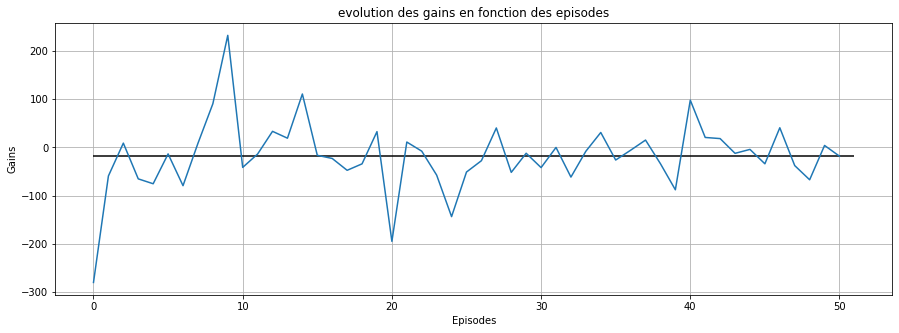

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(total_profits);
plt.hlines(np.mean(total_profits),0,len(total_profits))
plt.xlabel('Episodes')
plt.ylabel('Gains');
plt.title('evolution des gains en fonction des episodes');
plt.grid()

$\textbf{Resultats}:$ 
- On oberve que l"evolution des gains est assez érratique.En effet les oscillations du gain pour chaque épisode sont compris entre -200 et 150.De plus il apparait qu'en moyenne l'agent subit des pertes puisque le gain cumulé sur toutes les experiences est de -1576.

## 2 Prédicteurs:

L’état dans le code originel ne contient que des prédicteurs basés sur les n prix précédents. Nous ajoutons d'autres prédicteurs :
- Les ratios $OHLC$ c 'est a dire $np.log(High/Open)$ , $np.log(Low/Open)$ , $np.log(Close/Open)$ . 
- La position de l’investisseur
- Les gains depuis l’ouverture de la position

> On modifie la fonction getStock pour y integrer les ratios OHLC ainsi que la fonction getstate pour adapter le format à l'application de la fonction sigmoid.

In [ ]:
def getStockDataVec(key):
  vec = pd.read_csv('data/' + key +'.csv',index_col=0)
  Close = vec["Close"].values ; 
  HO = np.log(vec["High"].values/vec["Open"].values); # high / open
  LO = np.log(vec["Low"].values/vec["Open"].values) ; # Low / open
  CO = np.log(vec["Close"].values/vec["Open"].values) # Close / open
  data = pd.DataFrame(data = { "Close" : Close, "HO" : HO , "LO" : LO ,"CO" : CO })

  return data

DATA =  getStockDataVec(stock_name)

>  On modifit le getState car la fonction précdente ne prenait pas en charge plusieurs features.

In [ ]:
def getState(data, t, n):
  d = t - n + 1 ; res = np.zeros((data.shape[1],n-1))
  for j in range(data.shape[1]):
    block = data[d:t + 1,j] if d >= 0 else -d * [data[0,j]] + list(data[0:t + 1,j]) # pad with t0
    #print(block)
    for i in range(n - 1):
      res[j,i] = sigmoid(block[i + 1] - block[i]) # calcul de la fonction sigmoid de la differences des prix entre t+1 et t 

  return res.flatten().tolist() ## retourn la list des sigmoids des n-1 diff de prix
state = getState(np.array(DATA), 0, window_size + 1)

> On definit une nouvelle fonction train car on introduit aussi la Position de l’investisseur et le gain depuis l’ouverture de la position.

In [ ]:
#####   Train 

def Qfit(stock_name,window_size,batch_size,episode_count):
  
  #model = load_model("models/" + model_name)
  #window_size = model.layers[0].input.shape.as_list()[1]
  #print(window_size)
  agent = Agent(state_size = window_size*4 + 2)
  data = getStockDataVec(stock_name) ## retourne la serie de prix du stock (= dans notre cas le S&P500)
  l = data.shape[0] - 1
  print(l)
  batch_size = batch_size

  total_profits = []

  epsilon0 = agent.epsilon


  for e in tqdm(range(episode_count + 1)):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(np.array(data), 0, window_size + 1)

    total_profit = 0 ## profit initialisé a 0 au debut de l'episode 
    agent.inventory = []
    ## On initialise la position de l'investisseur  : 0 sit ; 1 buy et 2 sell
    current_pos = 0
    Gain_current_pos = 0

    for t in range(l):
      #print(t)
      ## la fonction act fait appel au reseaux dense si on ne tombe pas dans le cas ou il decide d'explorer
      #features = np.concatenate((state,current_pos,Gain_current_pos),axis = 0).reshape(1,-1)
      features = np.array(state + [current_pos] + [Gain_current_pos])
      #print(state.shape)
      #print(features.shape)
      #print(f"agent size : {agent.state_size}")
      action = agent.act(features)## on rajoute les features total_profits et current_pos

      # sit
      next_state = getState(np.array(data), t + 1, window_size + 1)
      reward = 0

      if action == 1 and len(agent.inventory) == 0:  # buy
        agent.inventory.append(data.Close[t])
        print("Buy: " + str(t)+" "+formatPrice(data.Close[t]))

        if agent.epsilon > agent.epsilon_min:
          agent.epsilon *= agent.epsilon_decay 


      elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data.Close[t] - bought_price, 0)
        total_profit += data.Close[t] - bought_price
        print("Sell: " +str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(data.Close[t] - bought_price))
        if agent.epsilon > agent.epsilon_min:
          agent.epsilon *= agent.epsilon_decay 

      Gain_current_pos = reward

      done = True if t == l - 1 else False
      agent.memory.append((state, action, reward, next_state, done))
      state = next_state
      #print(state.shape)

      if not done and len(agent.memory) > batch_size and t % batch_size ==0:
        #lprint("replaying")
        agent.expReplay(batch_size)

      if done: 
        print(f"Done and len agent inventory : {agent.inventory}")
        if len(agent.inventory) > 0:
          if agent.inventory[0] > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data.Close[t] - bought_price, 0)
            total_profit += data.Close[t] - bought_price
            print("Sell: " +str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(data.Close[t] - bought_price))
        if len(agent.inventory) > 0:
          if agent.inventory[0] < 0:
            vad = np.abs(agent.inventory.pop(0))
            reward = max(vad  - data.Close[t], 0)
            total_profit +=  vad  - data.Close[t]
            print("Debouclage Vad: " + str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(vad  - data.Close[t]))
        print("--------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")
        total_profits.append(total_profit)


    if e % 10 == 0:
      agent.model.save("/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD7/models/model_ep" + str(e))

  print(total_profits)
  return total_profits

In [ ]:
## Set Parameters
stock_name, window_size, episode_count = '^GSPC_2011', int(10), int(50)

In [ ]:
##### DQN fit
total_profits = Qfit(stock_name,window_size,batch_size,episode_count)

251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Episode 0/50
Buy: 3 $1273.85
Sell: 4 $1271.50 | Profit: -$2.35
Buy: 5 $1269.75
Sell: 13 $1283.35 | Profit: $13.60
Buy: 14 $1290.84
Sell: 15 $1291.18 | Profit: $0.34
Buy: 18 $1276.34
Sell: 20 $1307.59 | Profit: $31.25
Buy: 21 $1304.03
Sell: 23 $1310.87 | Profit: $6.84
Buy: 24 $1319.05
Sell: 25 $1324.57 | Profit: $5.52
Buy: 26 $1320.88


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Sell: 39 $1306.33 | Profit: -$14.55
Buy: 40 $1308.44
Sell: 50 $1256.88 | Profit: -$51.56
Buy: 53 $1298.38
Sell: 54 $1293.77 | Profit: -$4.61
Buy: 55 $1297.54
Sell: 60 $1328.26 | Profit: $30.72
Buy: 70 $1314.41
Sell: 71 $1314.52 | Profit: $0.11
Buy: 76 $1337.38
Sell: 77 $1335.25 | Profit: -$2.13
Buy: 78 $1347.24
Sell: 79 $1355.66 | Profit: $8.42
Buy: 80 $1360.48
Sell: 83 $1356.62 | Profit: -$3.86
Buy: 85 $1335.10
Sell: 101 $1331.10 | Profit: -$4.00
Buy: 109 $1289.00
Sell: 115 $1271.50 | Profit: -$17.50
Buy: 116 $1278.36
Sell: 118 $1287.14 | Profit: $8.78
Buy: 119 $1283.50
Sell: 133 $1308.87 | Profit: $25.37
Buy: 140 $1337.43
Sell: 142 $1304.89 | Profit: -$32.54
Buy: 145 $1286.94
Sell: 146 $1254.05 | Profit: -$32.89
Buy: 156 $1192.76
Sell: 157 $1193.89 | Profit: $1.13
Buy: 162 $1177.60
Sell: 164 $1176.80 | Profit: -$0.80
Buy: 166 $1212.92
Sell: 167 $1218.89 | Profit: $5.97
Buy: 168 $1204.42
Sell: 171 $1198.62 | Profit: -$5.80
Buy: 172 $1185.90
Sell: 176 $1188.68 | Profit: $2.78
Buy: 181 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Buy: 1 $1270.20
Sell: 2 $1276.56 | Profit: $6.36
Buy: 7 $1285.96
Sell: 8 $1283.76 | Profit: -$2.20
Buy: 10 $1295.02
Sell: 12 $1280.26 | Profit: -$14.76
Buy: 17 $1299.54
Sell: 18 $1276.34 | Profit: -$23.20
Buy: 19 $1286.12
Sell: 20 $1307.59 | Profit: $21.47
Buy: 21 $1304.03
Sell: 22 $1307.10 | Profit: $3.07
Buy: 23 $1310.87
Sell: 25 $1324.57 | Profit: $13.70
Buy: 26 $1320.88
Sell: 27 $1321.87 | Profit: $0.99
Buy: 28 $1329.15
Sell: 29 $1332.32 | Profit: $3.17
Buy: 30 $1328.01
Sell: 32 $1340.43 | Profit: $12.42
Buy: 39 $1306.33
Sell: 42 $1321.15 | Profit: $14.82
Buy: 53 $1298.38
Sell: 54 $1293.77 | Profit: -$4.61
Buy: 55 $1297.54
Sell: 56 $1309.66 | Profit: $12.12
Buy: 64 $1332.63
Sell: 65 $1335.54 | Profit: $2.91
Buy: 75 $1330.36
Sell: 81 $1363.61 | Profit: $33.25
Buy: 94 $1340.68
Sell: 104 $1312.94 | Profit: -$27.74
Buy: 105 $1300.16
Sell: 111 $1271.83 | Profit: -$28.33
Buy: 112 $1287.87
Sell: 114 $1267.64 | Profit: -$20.23
Buy: 117 $1295.52
Sell: 121 $1280.10 | Profit: -$15.42
Buy: 122

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Buy: 3 $1273.85
Sell: 16 $1296.63 | Profit: $22.78
Buy: 51 $1273.72
Sell: 73 $1305.14 | Profit: $31.42
Buy: 102 $1345.20
Sell: 135 $1305.44 | Profit: -$39.76
Buy: 154 $1178.81
Sell: 177 $1209.11 | Profit: $30.30
Buy: 217 $1239.70
Done and len agent inventory : [1239.699951]
Sell: 250 $1263.02 | Profit: $23.32
--------------------------------
Total Profit: $68.06
--------------------------------
Episode 12/50
Buy: 3 $1273.85
Sell: 12 $1280.26 | Profit: $6.41
Buy: 24 $1319.05
Sell: 42 $1321.15 | Profit: $2.10
Buy: 46 $1295.11
Sell: 70 $1314.41 | Profit: $19.30
Buy: 125 $1339.67
Sell: 126 $1337.88 | Profit: -$1.79
Buy: 130 $1319.49
Sell: 139 $1345.02 | Profit: $25.53
Buy: 141 $1331.94
Sell: 182 $1129.56 | Profit: -$202.38
Buy: 187 $1160.40
Sell: 197 $1203.66 | Profit: $43.26
Buy: 200 $1225.38
Sell: 222 $1216.13 | Profit: -$9.25
Buy: 223 $1215.65
Sell: 236 $1234.35 | Profit: $18.70
Buy: 237 $1255.19
Sell: 244 $1241.30 | Profit: -$13.89
Done and len agent inventory : []
--------------------

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Sell: 24 $1319.05 | Profit: $47.18
Buy: 26 $1320.88
Sell: 30 $1328.01 | Profit: $7.13
Buy: 32 $1340.43
Sell: 66 $1333.51 | Profit: -$6.92
Buy: 67 $1328.17
Sell: 111 $1271.83 | Profit: -$56.34
Buy: 112 $1287.87
Sell: 138 $1343.80 | Profit: $55.93
Buy: 140 $1337.43
Done and len agent inventory : [1337.430054]
Sell: 250 $1263.02 | Profit: -$74.41
--------------------------------
Total Profit: -$27.43
--------------------------------
Episode 22/50
Buy: 0 $1271.87
Sell: 13 $1283.35 | Profit: $11.48
Buy: 34 $1315.44
Sell: 39 $1306.33 | Profit: -$9.11
Buy: 43 $1310.13
Sell: 150 $1119.46 | Profit: -$190.67
Buy: 151 $1172.53
Sell: 162 $1177.60 | Profit: $5.07
Buy: 169 $1173.97
Sell: 210 $1218.28 | Profit: $44.31
Buy: 212 $1261.15
Done and len agent inventory : [1261.150024]
Sell: 250 $1263.02 | Profit: $1.87
--------------------------------
Total Profit: -$137.05
--------------------------------
Episode 23/50
Buy: 0 $1271.87
Sell: 7 $1285.96 | Profit: $14.09
Buy: 9 $1293.24
Sell: 89 $1342.08 | 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Sell: 1 $1270.20 | Profit: -$1.67
Buy: 4 $1271.50
Sell: 6 $1274.48 | Profit: $2.98
Buy: 11 $1281.92
Sell: 13 $1283.35 | Profit: $1.43
Buy: 15 $1291.18
Sell: 16 $1296.63 | Profit: $5.45
Buy: 18 $1276.34
Sell: 20 $1307.59 | Profit: $31.25
Buy: 22 $1307.10
Sell: 23 $1310.87 | Profit: $3.77
Buy: 25 $1324.57
Sell: 26 $1320.88 | Profit: -$3.69
Buy: 27 $1321.87
Sell: 29 $1332.32 | Profit: $10.45
Buy: 33 $1343.01
Sell: 161 $1162.35 | Profit: -$180.66
Buy: 217 $1239.70
Sell: 218 $1263.85 | Profit: $24.15
Buy: 220 $1257.81
Sell: 221 $1236.91 | Profit: -$20.90
Buy: 223 $1215.65
Sell: 224 $1192.98 | Profit: -$22.67
Done and len agent inventory : []
--------------------------------
Total Profit: -$150.11
--------------------------------
Episode 32/50
Buy: 12 $1280.26
Sell: 13 $1283.35 | Profit: $3.09
Buy: 33 $1343.01
Sell: 38 $1327.22 | Profit: -$15.79
Buy: 40 $1308.44
Sell: 41 $1330.97 | Profit: $22.53
Buy: 43 $1310.13
Sell: 44 $1321.82 | Profit: $11.69
Buy: 46 $1295.11
Sell: 47 $1304.28 | Profit:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Sell: 161 $1162.35 | Profit: -$109.52
Buy: 193 $1155.46
Done and len agent inventory : [1155.459961]
Sell: 250 $1263.02 | Profit: $107.56
--------------------------------
Total Profit: -$1.96
--------------------------------
Episode 42/50
Buy: 8 $1283.76
Sell: 9 $1293.24 | Profit: $9.48
Buy: 33 $1343.01
Sell: 72 $1319.68 | Profit: -$23.33
Buy: 73 $1305.14
Sell: 82 $1361.22 | Profit: $56.08
Buy: 84 $1347.32
Sell: 86 $1340.20 | Profit: -$7.12
Buy: 89 $1342.08
Sell: 94 $1340.68 | Profit: -$1.40
Buy: 95 $1343.60
Sell: 161 $1162.35 | Profit: -$181.25
Buy: 193 $1155.46
Sell: 206 $1242.00 | Profit: $86.54
Buy: 208 $1285.09
Done and len agent inventory : [1285.089966]
Sell: 250 $1263.02 | Profit: -$22.07
--------------------------------
Total Profit: -$83.07
--------------------------------
Episode 43/50
Buy: 0 $1271.87
Sell: 51 $1273.72 | Profit: $1.85
Buy: 97 $1317.37
Sell: 101 $1331.10 | Profit: $13.73
Buy: 104 $1312.94
Sell: 106 $1286.17 | Profit: -$26.77
Buy: 111 $1271.83
Sell: 113 $1265.

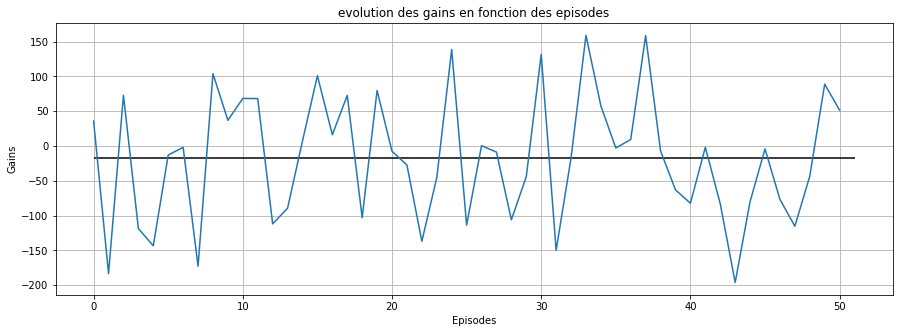

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(total_profits);
plt.hlines(np.mean(total_profits),0,len(total_profits))
plt.xlabel('Episodes')
plt.ylabel('Gains');
plt.title('evolution des gains en fonction des episodes');
plt.grid()

##3 Hyperparamètres:

* Dans cette partie nous allons introduire la possiblité de prendre des poitions shorts  et ainsi analyser l'impact sur le gain de l'agent.

* Nous  modifierons l'architecture du reseaux en faisant varier le nombre de couches et le nombre de neurones par couches afin d'étudier l'influences de ces paramétres sur le modéle. 

### On Modifie le code pour permettre les ventes à decouvert.

In [ ]:
#####   Train 

def Qfit(stock_name,window_size,batch_size,episode_count):
  
  agent = Agent(state_size = window_size*4 + 2)
  data = getStockDataVec(stock_name) ## retourne la serie de prix du stock (= dans notre cas le S&P500)
  l = data.shape[0] - 1
  batch_size = batch_size

  total_profits = []

  epsilon0 = agent.epsilon


  for e in tqdm(range(episode_count + 1)):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(np.array(data), 0, window_size + 1)

    total_profit = 0 ## profit initialisé a 0 au debut de l'episode 
    agent.inventory = []
    ## On initialise la position de l'investisseur  : 0 sit ; 1 buy et 2 sell
    current_pos = 0
    Gain_current_pos = 0

    for t in range(l):
      features = np.array(state + [current_pos] + [Gain_current_pos])
      action = agent.act(features)## on rajoute les features total_profits et current_pos

      # sit
      next_state = getState(np.array(data), t + 1, window_size + 1)
      reward = 0

      if action == 1 :
        if len(agent.inventory) == 0:  # on est dans le cas ou le porteufeuille est vide et on achete l'actif
          agent.inventory.append(data.Close[t])
          print("Buy: " + str(t)+" "+formatPrice(data.Close[t]))
        if len(agent.inventory) > 0 and agent.inventory[0] < 0 :## on est dans le cas ou on ferme la postion de vente à decouvert
          vad = np.abs(agent.inventory.pop(0))
          reward = max(vad  - data.Close[t], 0)
          total_profit +=  vad  - data.Close[t]
          print("Debouclage Vad: " + str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(vad  - data.Close[t]))
        if agent.epsilon > agent.epsilon_min:
          agent.epsilon *= agent.epsilon_decay 


      elif action == 2 :
        if len(agent.inventory) == 0: # vente à decouvert
          agent.inventory.append(-data.Close[t])
          print("Open Vad: " +str(t)+" "+ formatPrice(-data.Close[t]))
        if len(agent.inventory) > 0 and agent.inventory[0] > 0 : # sell
          bought_price = agent.inventory.pop(0)
          reward = max(data.Close[t] - bought_price, 0)
          total_profit += data.Close[t] - bought_price
          print("Sell: " +str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(data.Close[t] - bought_price))
        if agent.epsilon > agent.epsilon_min:
          agent.epsilon *= agent.epsilon_decay 


      current_pos = action
      Gain_current_pos = reward

      done = True if t == l - 1 else False
      agent.memory.append((state, action, reward, next_state, done))
      state = next_state
      #print(state.shape)

      #print(agent.inventory)

      if not done and len(agent.memory) > batch_size and t % batch_size ==0:
        #lprint("replaying")
        agent.expReplay(batch_size)

      if done:
        print(f"Done and len agent inventory : {agent.inventory}")
        if len(agent.inventory) > 0:
          if agent.inventory[0] > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data.Close[t] - bought_price, 0)
            total_profit += data.Close[t] - bought_price
            print("Sell: " +str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(data.Close[t] - bought_price))
        if len(agent.inventory) > 0:
          if agent.inventory[0] < 0:
            vad = np.abs(agent.inventory.pop(0))
            reward = max(vad  - data.Close[t], 0)
            total_profit +=  vad  - data.Close[t]
            print("Debouclage Vad: " + str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(vad  - data.Close[t]))
        print("--------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")
        total_profits.append(total_profit)


    if e % 10 == 0:
      agent.model.save("/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD7/models/model_ep" + str(e))
      

  print(total_profits)
  return total_profits

In [ ]:
## Set Parameters
stock_name, window_size, episode_count,= '^GSPC_2011', int(10), int(50) 
##### DQN fit
total_profits = Qfit(stock_name,window_size,batch_size,episode_count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episode 0/50
Open Vad: 1 -$1270.20
Debouclage Vad: 4 $1271.50 | Profit: -$1.30
Buy: 7 $1285.96
Sell: 10 $1295.02 | Profit: $9.06
Open Vad: 12 -$1280.26
Debouclage Vad: 17 $1299.54 | Profit: -$19.28
Buy: 18 $1276.34
Sell: 24 $1319.05 | Profit: $42.71
Open Vad: 25 -$1324.57
Debouclage Vad: 26 $1320.88 | Profit: $3.69
Buy: 27 $1321.87
Sell: 28 $1329.15 | Profit: $7.28
Buy: 29 $1332.32
Sell: 34 $1315.44 | Profit: -$16.88
Open Vad: 35 -$1307.40
Debouclage Vad: 36 $1306.10 | Profit: $1.30
Open Vad: 37 -$1319.88
Debouclage Vad: 38 $1327.22 | Profit: -$7.34
Open Vad: 39 -$1306.33
Debouclage Vad: 41 $1330.97 | Profit: -$24.64
Buy: 42 $1321.15
Sell: 45 $1320.02 | Profit: -$1.13
Buy: 46 $1295.11
Sell: 49 $1281.87 | Profit: -$13.24
Buy: 52 $1279.21
Sell: 58 $1310.19 | Profit: $30.98
Open Vad: 59 -$1319.44
Debouclage Vad: 61 $1325.83 | Profit: -$6.39
Open Vad: 62 -$1332.41
Debouclage Vad: 65 $1335.54 | Profit: -$3.13
Open Vad: 66 -$1333.51
Debouclage Vad: 67 $1328.17 | Profit: $5.34
Buy: 69 $1314.1

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Sell: 2 $1276.56 | Profit: $4.69
Buy: 3 $1273.85
Sell: 6 $1274.48 | Profit: $0.63
Open Vad: 7 -$1285.96
Debouclage Vad: 8 $1283.76 | Profit: $2.20
Buy: 9 $1293.24
Sell: 10 $1295.02 | Profit: $1.78
Open Vad: 11 -$1281.92
Debouclage Vad: 13 $1283.35 | Profit: -$1.43
Open Vad: 14 -$1290.84
Debouclage Vad: 15 $1291.18 | Profit: -$0.34
Buy: 16 $1296.63
Sell: 30 $1328.01 | Profit: $31.38
Buy: 31 $1336.32
Sell: 53 $1298.38 | Profit: -$37.94
Buy: 54 $1293.77
Sell: 57 $1313.80 | Profit: $20.03
Buy: 58 $1310.19
Sell: 64 $1332.63 | Profit: $22.44
Buy: 65 $1335.54
Sell: 71 $1314.52 | Profit: -$21.02
Buy: 72 $1319.68
Sell: 74 $1312.62 | Profit: -$7.06
Buy: 75 $1330.36
Sell: 96 $1333.27 | Profit: $2.91
Open Vad: 110 -$1270.98
Debouclage Vad: 111 $1271.83 | Profit: -$0.85
Buy: 112 $1287.87
Sell: 117 $1295.52 | Profit: $7.65
Buy: 118 $1287.14
Sell: 120 $1268.45 | Profit: -$18.69
Buy: 121 $1280.10
Sell: 127 $1339.22 | Profit: $59.12
Open Vad: 128 -$1353.22
Debouclage Vad: 129 $1343.80 | Profit: $9.42
B

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Open Vad: 17 -$1299.54
Debouclage Vad: 19 $1286.12 | Profit: $13.42
Open Vad: 20 -$1307.59
Debouclage Vad: 21 $1304.03 | Profit: $3.56
Buy: 22 $1307.10
Done and len agent inventory : [1307.099976]
Sell: 250 $1263.02 | Profit: -$44.08
--------------------------------
Total Profit: -$27.10
--------------------------------
Episode 12/50
Open Vad: 43 -$1310.13
Debouclage Vad: 44 $1321.82 | Profit: -$11.69
Buy: 45 $1320.02
Sell: 140 $1337.43 | Profit: $17.41
Open Vad: 141 -$1331.94
Debouclage Vad: 142 $1304.89 | Profit: $27.05
Buy: 143 $1300.67
Done and len agent inventory : [1300.670044]
Sell: 250 $1263.02 | Profit: -$37.65
--------------------------------
Total Profit: -$4.88
--------------------------------
Episode 13/50
Buy: 39 $1306.33
Sell: 50 $1256.88 | Profit: -$49.45
Buy: 51 $1273.72
Done and len agent inventory : [1273.719971]
Sell: 250 $1263.02 | Profit: -$10.70
--------------------------------
Total Profit: -$60.15
--------------------------------
Episode 14/50
Buy: 23 $1310.87


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Open Vad: 33 -$1343.01
Debouclage Vad: 34 $1315.44 | Profit: $27.57
Open Vad: 35 -$1307.40
Debouclage Vad: 36 $1306.10 | Profit: $1.30
Buy: 37 $1319.88
Sell: 161 $1162.35 | Profit: -$157.53
Open Vad: 162 -$1177.60
Debouclage Vad: 193 $1155.46 | Profit: $22.14
Open Vad: 194 -$1194.89
Debouclage Vad: 195 $1195.54 | Profit: -$0.65
Buy: 196 $1207.25
Done and len agent inventory : [1207.25]
Sell: 250 $1263.02 | Profit: $55.77
--------------------------------
Total Profit: -$51.40
--------------------------------
Episode 22/50
Buy: 48 $1296.39
Sell: 128 $1353.22 | Profit: $56.83
Open Vad: 129 -$1343.80
Debouclage Vad: 130 $1319.49 | Profit: $24.31
Open Vad: 131 -$1313.64
Debouclage Vad: 132 $1317.72 | Profit: -$4.08
Buy: 133 $1308.87
Done and len agent inventory : [1308.869995]
Sell: 250 $1263.02 | Profit: -$45.85
--------------------------------
Total Profit: $31.21
--------------------------------
Episode 23/50
Open Vad: 225 -$1188.04
Debouclage Vad: 226 $1161.79 | Profit: $26.25
Buy: 227 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Open Vad: 212 -$1261.15
Debouclage Vad: 213 $1253.23 | Profit: $7.92
Open Vad: 214 -$1261.12
Debouclage Vad: 215 $1275.92 | Profit: -$14.80
Buy: 216 $1229.10
Done and len agent inventory : [1229.099976]
Sell: 250 $1263.02 | Profit: $33.92
--------------------------------
Total Profit: $27.04
--------------------------------
Episode 32/50
Buy: 0 $1271.87
Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 33/50
Open Vad: 4 -$1271.50
Debouclage Vad: 5 $1269.75 | Profit: $1.75
Open Vad: 6 -$1274.48
Debouclage Vad: 7 $1285.96 | Profit: -$11.48
Buy: 8 $1283.76
Sell: 114 $1267.64 | Profit: -$16.12
Buy: 115 $1271.50
Done and len agent inventory : [1271.5]
Sell: 250 $1263.02 | Profit: -$8.48
--------------------------------
Total Profit: -$34.33
--------------------------------
Episode 34/50
Done and len agent inventory : []
--------------------------------
Total Profit: 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Buy: 1 $1270.20
Sell: 2 $1276.56 | Profit: $6.36
Open Vad: 3 -$1273.85
Debouclage Vad: 33 $1343.01 | Profit: -$69.16
Buy: 34 $1315.44
Done and len agent inventory : [1315.439941]
Sell: 250 $1263.02 | Profit: -$52.42
--------------------------------
Total Profit: -$115.22
--------------------------------
Episode 42/50
Buy: 68 $1324.46
Done and len agent inventory : [1324.459961]
Sell: 250 $1263.02 | Profit: -$61.44
--------------------------------
Total Profit: -$61.44
--------------------------------
Episode 43/50
Open Vad: 4 -$1271.50
Debouclage Vad: 5 $1269.75 | Profit: $1.75
Open Vad: 6 -$1274.48
Debouclage Vad: 7 $1285.96 | Profit: -$11.48
Buy: 38 $1327.22
Sell: 95 $1343.60 | Profit: $16.38
Open Vad: 96 -$1333.27
Debouclage Vad: 97 $1317.37 | Profit: $15.90
Open Vad: 98 -$1316.28
Debouclage Vad: 99 $1320.47 | Profit: -$4.19
Buy: 100 $1325.69
Sell: 161 $1162.35 | Profit: -$163.34
Buy: 162 $1177.60
Done and len agent inventory : [1177.599976]
Sell: 250 $1263.02 | Profit: $85.42
-----

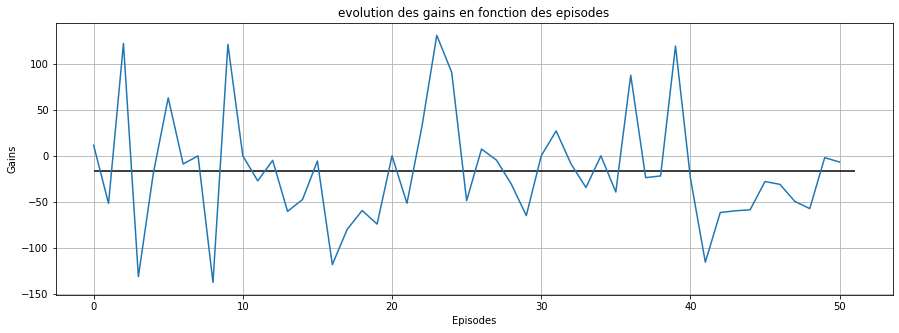

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(total_profits);
plt.hlines(np.mean(total_profits),0,len(total_profits))
plt.xlabel('Episodes')
plt.ylabel('Gains');
plt.title('evolution des gains en fonction des episodes');
plt.grid()

### On test plusieurs architectures :


On utilise 5 couches cachés avec : 
Une couche d'entree de 512 neurones
  - 1ere couche : 256 neurones
  - 2eme couche : 128 neurones
  - 3eme couche : 64 neurones
  - 4eme couche : 32 neurones
  - 5eme couche : 8 neurones
  
Une couche de sortie avec 3 neurones



In [ ]:
class Agent:
  def __init__(self, state_size, is_eval=False, model_name=""):
    self.state_size = state_size # normalized previous days
    self.action_size = 3 # sit, buy, sell
    self.memory = deque(maxlen=1000)
    self.inventory = []
    self.model_name = model_name
    self.is_eval = is_eval

    self.gamma = 0.95
    self.epsilon = 1
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995

    self.model = load_model("/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD7/models/" + model_name) if is_eval else self._model()

  def _model(self,):
    model = Sequential()
    model.add(Dense(units=512, input_dim=self.state_size, activation="relu"))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dense(self.action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))

    return model

  def act(self, state): ###Dans cette partie on choisit aleatoirement entre l exploration ou la predcition a partir de ce qui est connu
    if not self.is_eval and np.random.rand() <= self.epsilon:  ## Plus l'epsilon est petit , moins defois il va y avoir de phase d'exploration
      return random.randrange(self.action_size)
    #print("in act function")
    options = self.model.predict(state.reshape(1,-1))
    #print("out act function")
    return np.argmax(options[0])

  def expReplay(self, batch_size):
    mini_batch = []
    l = len(self.memory)
    indices = np.random.choice(len(self.memory), batch_size,
                replace=False)
    mini_batch=np.asarray(self.memory)[indices]  # faster
  #		for i in range(l - batch_size + 1, l):
  #			mini_batch.append(self.memory[i])

    for state, action, reward, next_state, done in mini_batch:
      target = reward
      ''''print(f"next state : {len(next_state)})")
      print(f"action : {action}")
      print(f"reward : {reward}")'''
      features = np.array(next_state + [action] + [reward]).reshape(1,-1)
      if not done:
        target = reward + self.gamma * np.amax(self.model.predict(features)[0])

      target_f = self.model.predict(np.array(state + [action] + [reward]).reshape(1,-1))
      #print("targetf step")
      target_f[0][action] = target
      self.model.fit(np.array(state + [action] + [reward]).reshape(1,-1), target_f, epochs=1, verbose=0)

In [ ]:
## Set Parameters
stock_name, window_size, episode_count = '^GSPC_2011', int(10), int(50)
##### DQN fit
total_profits = Qfit(stock_name, window_size,batch_size,episode_count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episode 0/50
Buy: 0 $1271.87
Sell: 4 $1271.50 | Profit: -$0.37
Buy: 5 $1269.75
Sell: 8 $1283.76 | Profit: $14.01
Buy: 13 $1283.35
Sell: 18 $1276.34 | Profit: -$7.01
Open Vad: 19 -$1286.12
Debouclage Vad: 20 $1307.59 | Profit: -$21.47
Buy: 21 $1304.03
Sell: 24 $1319.05 | Profit: $15.02
Open Vad: 25 -$1324.57
Debouclage Vad: 27 $1321.87 | Profit: $2.70
Open Vad: 28 -$1329.15
Debouclage Vad: 29 $1332.32 | Profit: -$3.17
Buy: 30 $1328.01
Sell: 31 $1336.32 | Profit: $8.31
Buy: 33 $1343.01
Sell: 34 $1315.44 | Profit: -$27.57
Buy: 35 $1307.40
Sell: 36 $1306.10 | Profit: -$1.30
Buy: 37 $1319.88
Sell: 41 $1330.97 | Profit: $11.09
Open Vad: 44 -$1321.82
Debouclage Vad: 46 $1295.11 | Profit: $26.71
Open Vad: 47 -$1304.28
Debouclage Vad: 50 $1256.88 | Profit: $47.40
Open Vad: 52 -$1279.21
Debouclage Vad: 53 $1298.38 | Profit: -$19.17
Buy: 54 $1293.77
Sell: 55 $1297.54 | Profit: $3.77
Buy: 56 $1309.66
Sell: 57 $1313.80 | Profit: $4.14
Open Vad: 59 -$1319.44
Debouclage Vad: 64 $1332.63 | Profit: -$1

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Buy: 5 $1269.75
Sell: 9 $1293.24 | Profit: $23.49
Buy: 16 $1296.63
Sell: 30 $1328.01 | Profit: $31.38
Buy: 31 $1336.32
Sell: 53 $1298.38 | Profit: -$37.94
Buy: 54 $1293.77
Sell: 62 $1332.41 | Profit: $38.64
Open Vad: 68 -$1324.46
Debouclage Vad: 72 $1319.68 | Profit: $4.78
Open Vad: 73 -$1305.14
Debouclage Vad: 77 $1335.25 | Profit: -$30.11
Open Vad: 78 -$1347.24
Debouclage Vad: 83 $1356.62 | Profit: -$9.38
Open Vad: 86 -$1340.20
Debouclage Vad: 91 $1337.77 | Profit: $2.43
Open Vad: 92 -$1329.47
Debouclage Vad: 93 $1328.98 | Profit: $0.49
Buy: 98 $1316.28
Sell: 144 $1292.28 | Profit: -$24.00
Open Vad: 149 -$1199.38
Debouclage Vad: 162 $1177.60 | Profit: $21.78
Open Vad: 163 -$1159.27
Debouclage Vad: 166 $1212.92 | Profit: -$53.65
Open Vad: 168 -$1204.42
Debouclage Vad: 170 $1165.24 | Profit: $39.18
Buy: 178 $1216.01
Sell: 184 $1162.95 | Profit: -$53.06
Buy: 185 $1175.38
Sell: 193 $1155.46 | Profit: -$19.92
Open Vad: 196 -$1207.25
Debouclage Vad: 198 $1224.58 | Profit: -$17.33
Open Vad:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Buy: 1 $1270.20
Sell: 46 $1295.11 | Profit: $24.91
Buy: 47 $1304.28
Sell: 48 $1296.39 | Profit: -$7.89
Buy: 50 $1256.88
Sell: 51 $1273.72 | Profit: $16.84
Buy: 52 $1279.21
Done and len agent inventory : [1279.209961]
Sell: 250 $1263.02 | Profit: -$16.19
--------------------------------
Total Profit: $17.67
--------------------------------
Episode 12/50
Buy: 0 $1271.87
Sell: 5 $1269.75 | Profit: -$2.12
Open Vad: 6 -$1274.48
Debouclage Vad: 12 $1280.26 | Profit: -$5.78
Buy: 14 $1290.84
Sell: 33 $1343.01 | Profit: $52.17
Buy: 34 $1315.44
Sell: 36 $1306.10 | Profit: -$9.34
Buy: 37 $1319.88
Sell: 55 $1297.54 | Profit: -$22.34
Buy: 56 $1309.66
Sell: 59 $1319.44 | Profit: $9.78
Buy: 60 $1328.26
Sell: 61 $1325.83 | Profit: -$2.43
Buy: 62 $1332.41
Sell: 63 $1332.87 | Profit: $0.46
Buy: 64 $1332.63
Sell: 101 $1331.10 | Profit: -$1.53
Buy: 102 $1345.20
Sell: 103 $1314.55 | Profit: -$30.65
Buy: 104 $1312.94
Sell: 109 $1289.00 | Profit: -$23.94
Buy: 110 $1270.98
Sell: 115 $1271.50 | Profit: $0.52
B

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 22/50
Buy: 0 $1271.87
Sell: 173 $1154.23 | Profit: -$117.64
Buy: 174 $1162.27
Done and len agent inventory : [1162.27002]
Sell: 250 $1263.02 | Profit: $100.75
--------------------------------
Total Profit: -$16.89
--------------------------------
Episode 23/50
Open Vad: 15 -$1291.18
Debouclage Vad: 125 $1339.67 | Profit: -$48.49
Buy: 138 $1343.80
Sell: 208 $1285.09 | Profit: -$58.71
Open Vad: 209 -$1253.30
Debouclage Vad: 210 $1218.28 | Profit: $35.02
Done and len agent inventory : []
--------------------------------
Total Profit: -$72.18
--------------------------------
Episode 24/50
Open Vad: 3 -$1273.85
Debouclage Vad: 4 $1271.50 | Profit: $2.35
Buy: 5 $1269.75
Sell: 42 $1321.15 | Profit: $51.40
Open Vad: 51 -$1273.72
Debouclage Vad: 52 $1279.21 | Profit: -$5.49
Buy: 53 $1298.38
Sell: 59 $1319.44 | Profit: $21

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Debouclage Vad: 1 $1270.20 | Profit: $1.67
Buy: 2 $1276.56
Done and len agent inventory : [1276.560059]
Sell: 250 $1263.02 | Profit: -$13.54
--------------------------------
Total Profit: -$11.87
--------------------------------
Episode 32/50
Buy: 0 $1271.87
Sell: 35 $1307.40 | Profit: $35.53
Buy: 37 $1319.88
Done and len agent inventory : [1319.880005]
Sell: 250 $1263.02 | Profit: -$56.86
--------------------------------
Total Profit: -$21.33
--------------------------------
Episode 33/50
Buy: 0 $1271.87
Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 34/50
Buy: 0 $1271.87
Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 35/50
Buy: 0 $1271.87
Sell: 250 $1263.02 | Profit: -$8.85
Done and len agent inventory : []
-----------------------

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 42/50
Buy: 0 $1271.87
Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 43/50
Buy: 0 $1271.87
Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 44/50
Buy: 0 $1271.87
Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 45/50
Buy: 0 $1271.87
Sell: 69 $1314.16 | Profit: $42.29
Buy: 71 $1314.52
Sell: 89 $1342.08 | Profit: $27.56
Buy: 91 $1337.77
Done and len agent inventory : [1337.77002]
Sell: 250 $1263.02 | Profit: -$74.75
-----------------------

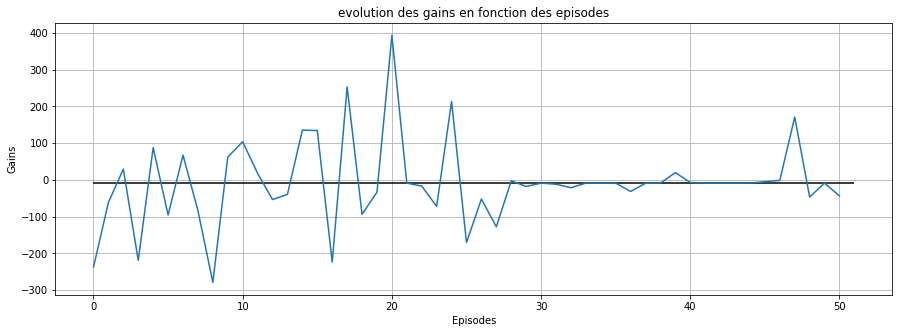

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(total_profits);
plt.hlines(np.mean(total_profits),0,len(total_profits))
plt.xlabel('Episodes')
plt.ylabel('Gains');
plt.title('evolution des gains en fonction des episodes');
plt.grid()

On utilise 1 couche d'entree de 32 neurones , une couche cachée de 8 et une couche de sortie avec 3 neurones.

In [ ]:
class Agent:
  def __init__(self, state_size, is_eval=False, model_name=""):
    self.state_size = state_size # normalized previous days
    self.action_size = 3 # sit, buy, sell
    self.memory = deque(maxlen=1000)
    self.inventory = []
    self.model_name = model_name
    self.is_eval = is_eval

    self.gamma = 0.95
    self.epsilon = 1
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995

    self.model = load_model("models/" + model_name) if is_eval else self._model()

  def _model(self,):
    model = Sequential()
    model.add(Dense(units=32, input_dim=self.state_size, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dense(self.action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))

    return model

  def act(self, state): ###Dans cette partie on choisit aleatoirement entre l exploration ou la predcition a partir de ce qui est connu
    if not self.is_eval and np.random.rand() <= self.epsilon:  ## Plus l'epsilon est petit , moins defois il va y avoir de phase d'exploration
      return random.randrange(self.action_size)
    #print("in act function")
    options = self.model.predict(state.reshape(1,-1))
    #print("out act function")
    return np.argmax(options[0])

  def expReplay(self, batch_size):
    mini_batch = []
    l = len(self.memory)
    indices = np.random.choice(len(self.memory), batch_size,
                replace=False)
    mini_batch=np.asarray(self.memory)[indices]  # faster
  #		for i in range(l - batch_size + 1, l):
  #			mini_batch.append(self.memory[i])

    for state, action, reward, next_state, done in mini_batch:
      target = reward
      ''''print(f"next state : {len(next_state)})")
      print(f"action : {action}")
      print(f"reward : {reward}")'''
      features = np.array(next_state + [action] + [reward]).reshape(1,-1)
      if not done:
        target = reward + self.gamma * np.amax(self.model.predict(features)[0])

      target_f = self.model.predict(np.array(state + [action] + [reward]).reshape(1,-1))
      #print("targetf step")
      target_f[0][action] = target
      self.model.fit(np.array(state + [action] + [reward]).reshape(1,-1), target_f, epochs=1, verbose=0)

In [ ]:
## Set Parameters
stock_name, window_size, episode_count = '^GSPC_2011', int(10), int(50) 
##### DQN fit
total_profits = Qfit(stock_name,window_size,batch_size,episode_count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episode 0/50
Buy: 0 $1271.87
Sell: 1 $1270.20 | Profit: -$1.67
Open Vad: 2 -$1276.56
Debouclage Vad: 4 $1271.50 | Profit: $5.06
Open Vad: 5 -$1269.75
Debouclage Vad: 8 $1283.76 | Profit: -$14.01
Buy: 10 $1295.02
Sell: 11 $1281.92 | Profit: -$13.10
Buy: 12 $1280.26
Sell: 17 $1299.54 | Profit: $19.28
Buy: 18 $1276.34
Sell: 19 $1286.12 | Profit: $9.78
Open Vad: 20 -$1307.59
Debouclage Vad: 21 $1304.03 | Profit: $3.56
Buy: 22 $1307.10
Sell: 26 $1320.88 | Profit: $13.78
Open Vad: 28 -$1329.15
Debouclage Vad: 30 $1328.01 | Profit: $1.14
Open Vad: 31 -$1336.32
Debouclage Vad: 34 $1315.44 | Profit: $20.88
Buy: 35 $1307.40
Sell: 36 $1306.10 | Profit: -$1.30
Open Vad: 37 -$1319.88
Debouclage Vad: 40 $1308.44 | Profit: $11.44
Open Vad: 41 -$1330.97
Debouclage Vad: 44 $1321.82 | Profit: $9.15
Open Vad: 47 -$1304.28
Debouclage Vad: 50 $1256.88 | Profit: $47.40
Buy: 51 $1273.72
Sell: 52 $1279.21 | Profit: $5.49
Open Vad: 53 -$1298.38
Debouclage Vad: 54 $1293.77 | Profit: $4.61
Buy: 55 $1297.54
Sell:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Debouclage Vad: 15 $1291.18 | Profit: -$19.31
Open Vad: 16 -$1296.63
Debouclage Vad: 30 $1328.01 | Profit: -$31.38
Open Vad: 31 -$1336.32
Debouclage Vad: 41 $1330.97 | Profit: $5.35
Open Vad: 42 -$1321.15
Debouclage Vad: 53 $1298.38 | Profit: $22.77
Buy: 54 $1293.77
Sell: 55 $1297.54 | Profit: $3.77
Open Vad: 56 -$1309.66
Debouclage Vad: 60 $1328.26 | Profit: -$18.60
Open Vad: 61 -$1325.83
Debouclage Vad: 98 $1316.28 | Profit: $9.55
Open Vad: 100 -$1325.69
Debouclage Vad: 101 $1331.10 | Profit: -$5.41
Open Vad: 102 -$1345.20
Debouclage Vad: 112 $1287.87 | Profit: $57.33
Buy: 113 $1265.42
Sell: 115 $1271.50 | Profit: $6.08
Buy: 116 $1278.36
Sell: 117 $1295.52 | Profit: $17.16
Open Vad: 118 -$1287.14
Debouclage Vad: 161 $1162.35 | Profit: $124.79
Buy: 163 $1159.27
Sell: 164 $1176.80 | Profit: $17.53
Buy: 165 $1210.08
Sell: 166 $1212.92 | Profit: $2.84
Open Vad: 167 -$1218.89
Debouclage Vad: 209 $1253.30 | Profit: -$34.41
Open Vad: 210 -$1218.28
Debouclage Vad: 220 $1257.81 | Profit: -$39

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Open Vad: 1 -$1270.20
Debouclage Vad: 129 $1343.80 | Profit: -$73.60
Buy: 131 $1313.64
Sell: 134 $1316.14 | Profit: $2.50
Buy: 135 $1305.44
Sell: 136 $1326.73 | Profit: $21.29
Buy: 137 $1325.84
Sell: 138 $1343.80 | Profit: $17.96
Buy: 139 $1345.02
Sell: 143 $1300.67 | Profit: -$44.35
Buy: 144 $1292.28
Sell: 147 $1260.34 | Profit: -$31.94
Open Vad: 148 -$1200.07
Debouclage Vad: 159 $1123.53 | Profit: $76.54
Buy: 160 $1123.82
Sell: 161 $1162.35 | Profit: $38.53
Buy: 162 $1177.60
Sell: 163 $1159.27 | Profit: -$18.33
Open Vad: 164 -$1176.80
Debouclage Vad: 225 $1188.04 | Profit: -$11.24
Buy: 226 $1161.79
Sell: 228 $1192.55 | Profit: $30.76
Buy: 229 $1195.19
Sell: 230 $1246.96 | Profit: $51.77
Buy: 231 $1244.58
Sell: 232 $1244.28 | Profit: -$0.30
Open Vad: 233 -$1257.08
Debouclage Vad: 236 $1234.35 | Profit: $22.73
Buy: 237 $1255.19
Sell: 242 $1219.66 | Profit: -$35.53
Buy: 243 $1205.35
Sell: 244 $1241.30 | Profit: $35.95
Buy: 245 $1243.72
Sell: 246 $1254.00 | Profit: $10.28
Buy: 247 $1265.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 22/50
Buy: 0 $1271.87
Sell: 193 $1155.46 | Profit: -$116.41
Buy: 194 $1194.89
Done and len agent inventory : [1194.890015]
Sell: 250 $1263.02 | Profit: $68.13
--------------------------------
Total Profit: -$48.28
--------------------------------
Episode 23/50
Buy: 1 $1270.20
Done and len agent inventory : [1270.199951]
Sell: 250 $1263.02 | Profit: -$7.18
--------------------------------
Total Profit: -$7.18
--------------------------------
Episode 24/50
Buy: 0 $1271.87
Sell: 102 $1345.20 | Profit: $73.33
Open Vad: 103 -$1314.55
Debouclage Vad: 104 $1312.94 | Profit: $1.61
Open Vad: 105 -$1300.16
Debouclage Vad: 106 $1286.17 | Profit: $13.99
Buy: 107 $1284.94
Done and len agent inventory : [1284.939941]
Sell: 250 $1263.02 | Profit: -$21.92
--------------------------------
Total Profit: $67.01
--------------------

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Sell: 9 $1293.24 | Profit: $21.37
Buy: 10 $1295.02
Sell: 11 $1281.92 | Profit: -$13.10
Buy: 12 $1280.26
Sell: 14 $1290.84 | Profit: $10.58
Buy: 15 $1291.18
Sell: 19 $1286.12 | Profit: -$5.06
Open Vad: 20 -$1307.59
Debouclage Vad: 21 $1304.03 | Profit: $3.56
Buy: 22 $1307.10
Sell: 27 $1321.87 | Profit: $14.77
Buy: 28 $1329.15
Sell: 29 $1332.32 | Profit: $3.17
Buy: 30 $1328.01
Sell: 56 $1309.66 | Profit: -$18.35
Open Vad: 57 -$1313.80
Debouclage Vad: 58 $1310.19 | Profit: $3.61
Buy: 59 $1319.44
Sell: 138 $1343.80 | Profit: $24.36
Buy: 139 $1345.02
Sell: 151 $1172.53 | Profit: -$172.49
Buy: 152 $1120.76
Sell: 171 $1198.62 | Profit: $77.86
Buy: 172 $1185.90
Sell: 175 $1172.87 | Profit: -$13.03
Buy: 176 $1188.68
Sell: 187 $1160.40 | Profit: -$28.28
Open Vad: 188 -$1131.42
Debouclage Vad: 191 $1144.03 | Profit: -$12.61
Buy: 192 $1164.97
Sell: 194 $1194.89 | Profit: $29.92
Buy: 195 $1195.54
Sell: 196 $1207.25 | Profit: $11.71
Buy: 197 $1203.66
Sell: 198 $1224.58 | Profit: $20.92
Buy: 199 $120

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done and len agent inventory : [1271.869995]
Sell: 250 $1263.02 | Profit: -$8.85
--------------------------------
Total Profit: -$8.85
--------------------------------
Episode 42/50
Buy: 0 $1271.87
Sell: 72 $1319.68 | Profit: $47.81
Buy: 73 $1305.14
Done and len agent inventory : [1305.140015]
Sell: 250 $1263.02 | Profit: -$42.12
--------------------------------
Total Profit: $5.69
--------------------------------
Episode 43/50
Buy: 0 $1271.87
Sell: 101 $1331.10 | Profit: $59.23
Buy: 102 $1345.20
Done and len agent inventory : [1345.199951]
Sell: 250 $1263.02 | Profit: -$82.18
--------------------------------
Total Profit: -$22.95
--------------------------------
Episode 44/50
Buy: 1 $1270.20
Sell: 126 $1337.88 | Profit: $67.68
Buy: 128 $1353.22
Sell: 186 $1151.06 | Profit: -$202.16
Buy: 187 $1160.40
Sell: 193 $1155.46 | Profit: -$4.94
Buy: 194 $1194.89
Sell: 195 $1195.54 | Profit: $0.65
Open Vad: 196 -$1207.25
Debouclage Vad: 197 $1203.66 | Profit: $3.59
Buy: 198 $1224.58
Sell: 199 $1

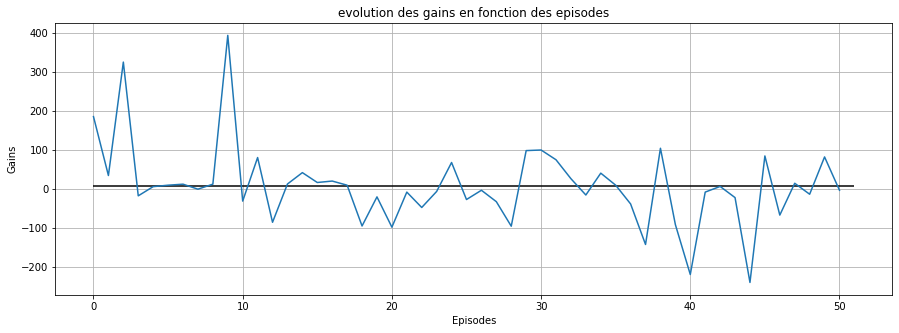

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(total_profits);
plt.hlines(np.mean(total_profits),0,len(total_profits))
plt.xlabel('Episodes')
plt.ylabel('Gains');
plt.title('evolution des gains en fonction des episodes');
plt.grid()

## 4 Test de la performance:

Nous choisissons une serie qui suit celle d'entrainement et nous evaluons le modéle sur cette nouvelle serie.Nous avons entrainé sur le SP500 sur l'année 2011 , nous utilisons donc l'année suivante. 


In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 11.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=345e6a455d4c48d3b9efbcbf8e3e103c31561276f8b0a799cebc29eb371261f6
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance
SP500_2012 = yfinance.download("^GSPC", start="2012-01-01", end="2012-12-31")

[*********************100%***********************]  1 of 1 completed


In [ ]:
SP500_2012

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000
...,...,...,...,...,...,...
2012-12-21,1443.670044,1443.670044,1422.579956,1430.150024,1430.150024,5229160000
2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1426.660034,1248960000
2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,1419.829956,2285030000


In [ ]:
## Set Parameters
stock_name, window_size, model_name = '^GSPC', int(10),"model_ep50"
start = "2012-01-01" ; end = "2012-12-31"

In [ ]:
def getStockData_Evalution(key,start,end):
  vec = yfinance.download(key, start = start, end = end)
  vec = pd.read_csv('data/' + key +'.csv',index_col=0)
  Close = vec["Close"].values ; 
  HO = np.log(vec["High"].values/vec["Open"].values); # high / open
  LO = np.log(vec["Low"].values/vec["Open"].values) ; # Low / open
  CO = np.log(vec["Close"].values/vec["Open"].values) # Close / open
  data = pd.DataFrame(data = { "Close" : Close, "HO" : HO , "LO" : LO ,"CO" : CO })

  return data

DATA =  getStockData_Evalution("^GSPC","2012-01-01","2012-12-31")

[*********************100%***********************]  1 of 1 completed


In [ ]:
####  Evaluate

def Q_evaluate(stock_name,start,end,window_size,batch_size,model_name):

  agent = Agent((window_size*4 + 2),True,model_name)
  data = getStockData_Evalution(stock_name,start,end) ## retourne la serie de prix du stock (= dans notre cas le S&P500)
  l = data.shape[0] - 1
  batch_size = batch_size

  total_profits = []

  epsilon0 = agent.epsilon
  state = getState(np.array(data), 0, window_size + 1)
  total_profit = 0
  agent.inventory = []
  current_pos = 0
  Gain_current_pos = 0

  
  for t in tqdm(range(l)):

    features = np.array(state + [current_pos] + [Gain_current_pos])
    action = agent.act(features)## on rajoute les features total_profits et current_pos

    # sit
    next_state = getState(np.array(data), t + 1, window_size + 1)
    reward = 0

    if action == 1 :
      if len(agent.inventory) == 0:  # on est dans le cas ou le porteufeuille est vide et on achete l'actif
        agent.inventory.append(data.Close[t])
        print("Buy: " + str(t)+" "+formatPrice(data.Close[t]))
      if len(agent.inventory) > 0 and agent.inventory[0] < 0 :## on est dans le cas ou on ferme la postion de vente à decouvert
        vad = np.abs(agent.inventory.pop(0))
        reward = max(vad  - data.Close[t], 0)
        total_profit +=  vad  - data.Close[t]
        print("Debouclage Vad: " + str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(vad  - data.Close[t]))


    elif action == 2 :
      if len(agent.inventory) == 0: # vente à decouvert
        agent.inventory.append(-data.Close[t])
        print("Open Vad: " +str(t)+" "+ formatPrice(-data.Close[t]))
      if len(agent.inventory) > 0 and agent.inventory[0] > 0 : # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data.Close[t] - bought_price, 0)
        total_profit += data.Close[t] - bought_price
        print("Sell: " +str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(data.Close[t] - bought_price))

    current_pos = action
    Gain_current_pos = reward


    done = True if t == l - 1 else False
    if done : 
        if len(agent.inventory) > 0:
          if agent.inventory[0] > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data.Close[t] - bought_price, 0)
            total_profit += data.Close[t] - bought_price
            print("Sell: " +str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(data.Close[t] - bought_price))
          if agent.inventory[0] < 0:
            vad = np.abs(agent.inventory.pop(0))
            reward = max(vad  - data.Close[t], 0)
            total_profit +=  vad  - data.Close[t]
            print("Debouclage Vad: " + str(t)+" "+ formatPrice(data.Close[t]) + " | Profit: " + formatPrice(vad  - data.Close[t]))


    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
      print ("--------------------------------")
      print (stock_name + " Total Profit: " + formatPrice(total_profit))
      print ("--------------------------------")

    #return total_profit


In [ ]:
Q_evaluate(stock_name,start,end,window_size,batch_size,model_name)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^GSPC_2011: No data found, symbol may be delisted


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Open Vad: 0 -$1271.87
Debouclage Vad: 250 $1263.02 | Profit: $8.85
--------------------------------
^GSPC_2011 Total Profit: $8.85
--------------------------------



> On constate que la meme position est consérvée tout au long de l'éxpérience.C'est assez contradictoire avec le comportement observé lors de l'entrainement sur les données précédentes.

> Il se peut que la généralisation d'une série a l'autre se fasse mal ou alors que l'information contenu dans les features ne soit plus la même sur cette nouvelles fenêtre de la serie.En effet les plages d'études sont proches de la crise de 2008.